In [304]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression, LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
import graphviz
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명 : 머신러닝알고리즘 이해 및 활용
- 평가일 : 03.10
- 성명 : 김기현
- 점수 : 77.5

Q1. iris data를 불러와서 아래 사항을 수행하세요.(15점)

- 결정트리 모델을 시각화하고 주요한 인사이트를 기술하세요.(tree.plot_tree or tree.export_graphviz 이용)
- Feature importance를 추출하고 시각화하세요.

정답

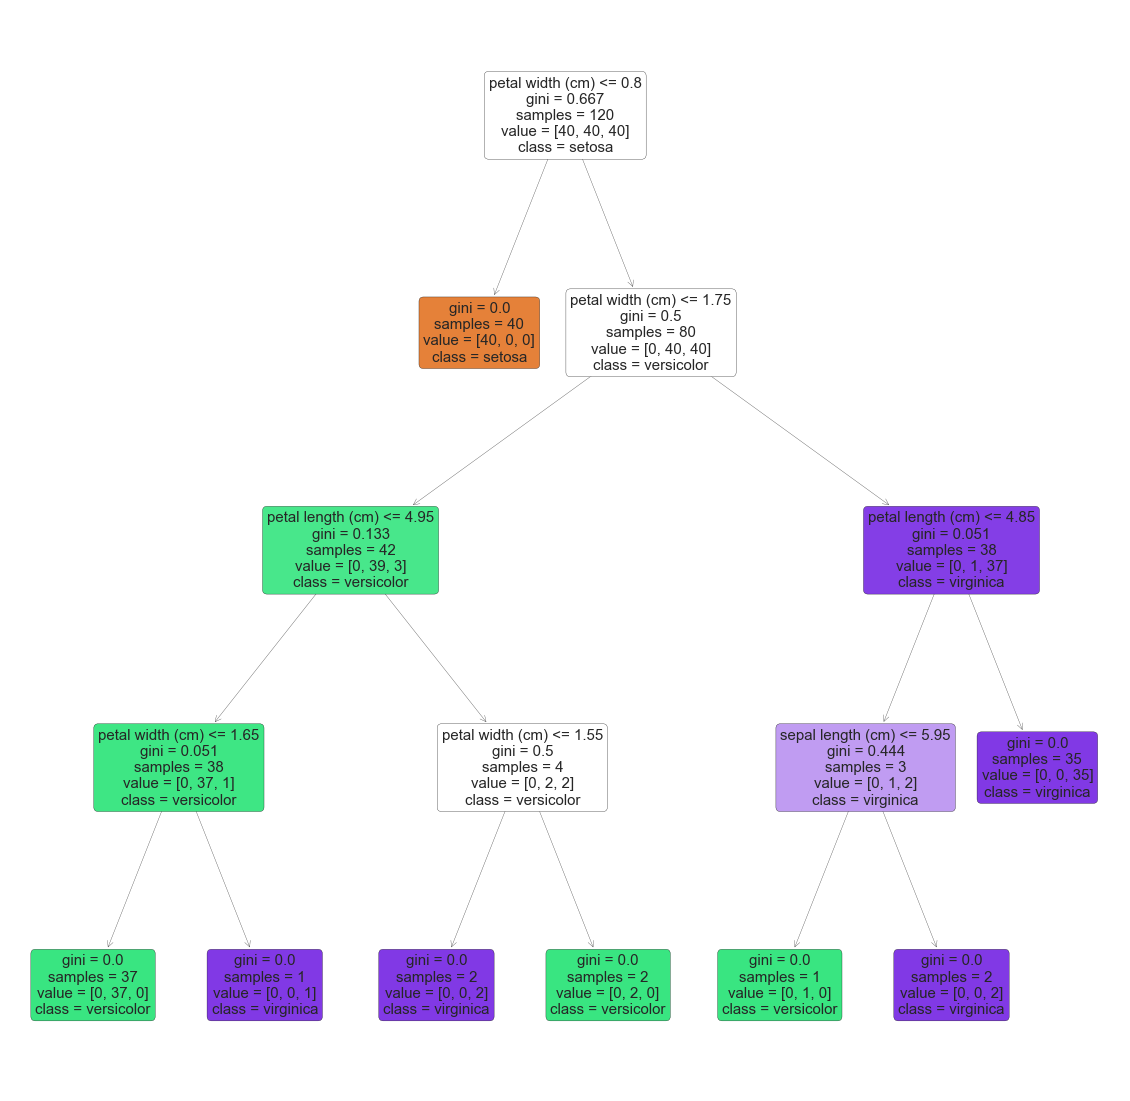

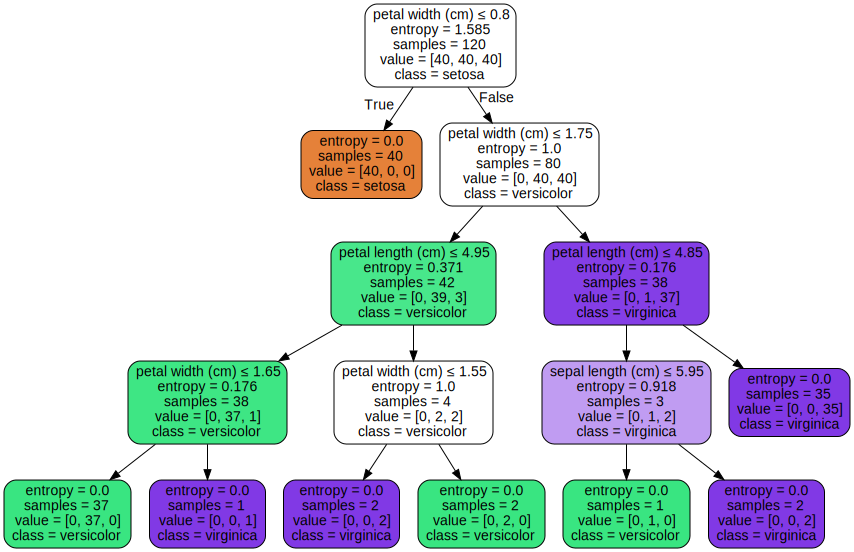

<Figure size 1440x1440 with 0 Axes>

In [366]:
# 엔트로피 또는 지니 불순도가 가장 낮은 방향을 찾아 분류를 진행한다

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

dt_clf = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
dt_clf.fit(X_train, y_train)

plt.figure(figsize = (20, 20))
tree.plot_tree(dt_clf, filled = True,
               feature_names = iris['feature_names'],
               class_names = iris['target_names'],
               rounded = True, fontsize = 15)
plt.show()

dt_clf1 = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt_clf1.fit(X_train, y_train)
plt.figure(figsize = (20, 20))
graph = tree.export_graphviz(dt_clf1, filled = True,
                             out_file = None,
                             feature_names = iris['feature_names'],
                             class_names = iris['target_names'],
                             rounded = True,
                             special_characters = True)
graphviz.Source(graph)

<AxesSubplot:>

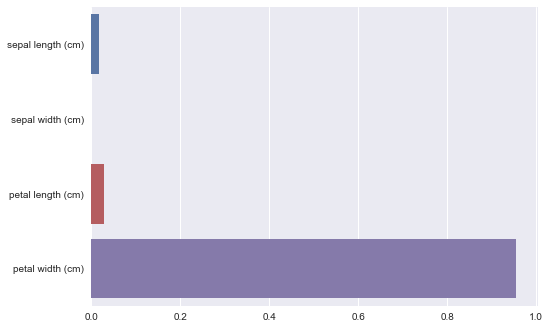

In [69]:
x = dt_clf.feature_importances_
sns.barplot(x, y = iris.feature_names)

Q2~Q3. 'dataset/creditcard.csv'를 불러와서 신용카드 사기 검출 분류문제를 아래와 같이 수행하세요(10점)
- 로지스틱 리그레션을 적용한 모델 학습 및 사용자 함수를 이용하여 평가
    - 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환하는 사용자 함수 생성
    - 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수(테스트 사이즈 0.3)
    - 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
    
- 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서  학습/예측/평가 수행
    - 사용자 함수를 사용하여 LightGBM으로 모델을 학습한 뒤 별도의 테스트 데이터 세트에서 예측 평가를 수행. 단, n_estimators=1000, num_leaves=64 적용<br>  ※ 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로 파라미터 설정(default=True). default 설정은 재현율, AUC 성능을 매우 크게 저하시킴
    - 넘파이의 np.log1p( )를 이용하여 Amount를 로그 변환하는하는 사용자 함수 생성
    - Amount를 로그 변환 후 로지스틱 회귀 및 LightGBM 수행.

정답
정답

In [84]:
card_df = pd.read_csv('./data/creditcard.csv')

def get_new_df(df):
    df1 = df.copy()
    df1.drop('Time', axis = 1, inplace = True)
    return df1
card_df1 = get_new_df(card_df)
card_df1.info()
card_df1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [367]:
X = card_df1.iloc[:, :-1]
y = card_df1.iloc[:, -1]

lr_clf = LogisticRegression(random_state = 0, n_jobs = -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

def get_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    print(f'오차행렬 : \n{confusion} \n\n정확도 : {accuracy:.3f} \n정밀도 : {precision:.3f} \n재현율 : {recall:.3f} \nf1 : {f1:.3f} \nauc : {auc:.3f}')
    
get_eval(y_test, pred, pred_proba)

오차행렬 : 
[[85285    11]
 [   55    92]] 

정확도 : 0.999 
정밀도 : 0.893 
재현율 : 0.626 
f1 : 0.736 
auc : 0.969


In [118]:
lgmb_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, random_state = 0, n_jobs = -1, boost_from_average = False)
lr_clf = LogisticRegression(random_state = 0, n_jobs = -1)

def get_log(df):
    df1 = df.copy()
    df1.Amount = np.log1p(df1.Amount)
    return df1

card_df2 = get_log(card_df1)
X = card_df2.iloc[:, :-1]
y = card_df2.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

for i in [lgmb_clf, lr_clf]:
    print(i)
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    pred_proba = i.predict_proba(X_test)[:, 1]
    get_eval(y_test, pred, pred_proba)
    print()

LGBMClassifier(boost_from_average=False, n_estimators=1000, num_leaves=64,
               random_state=0)
오차행렬 : 
[[85287     9]
 [   29   118]] 

정확도 : 0.9995552590615966 
정밀도 : 0.9291338582677166 
재현율 : 0.8027210884353742 
f1 : 0.8613138686131387 
auc : 0.9799826327079322

LogisticRegression(n_jobs=-1, random_state=0)
오차행렬 : 
[[85285    11]
 [   56    91]] 

정확도 : 0.9992158515033414 
정밀도 : 0.8921568627450981 
재현율 : 0.6190476190476191 
f1 : 0.7309236947791166 
auc : 0.9684553478116062



Q4. Q2 신용카드 사기 검출 분류문제에서 아래를 참고하여 이상치 데이터를 제거하고 모델 학습/예측/평가를 수행하세요(5점)
- 히트맵을 이용해 레이블과의 상관성을 시각화 
- 레이블과 상관성이 높은 피처를 위주로 이상치 검출하는 사용자 함수 생성
- 사용자 함수를 이용하여 이상치 검출
- 이상치 제거 사용자 함수를 이용하여 이상치 제거 후 로지스틱 회귀 및 LightGBM 수행 및 평가

정답

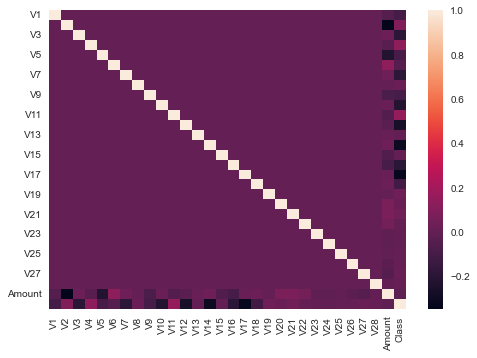

In [388]:
sns.heatmap(card_df2.corr())
a = card_df2.corr()['Class'][(card_df2.corr()['Class'] < -0.3) | (card_df2.corr()['Class'] > 0.3)].index

In [440]:
b = a.tolist()
b.remove('Class')
b

['V14', 'V17']

In [441]:
def del_outlier(df):
    df1 = df.copy()
    a = df1.corr()['Class'][(df1.corr()['Class'] < -0.3) | (df1.corr()['Class'] > 0.3)].index
    b = list(a)
    b.remove('Class')
    for i in b:
        fraud = df1[df1['Class'] == 1][i]
        quantile_25 = np.percentile(fraud.values, 25)
        quantile_75 = np.percentile(fraud.values, 75)

        iqr = quantile_75 - quantile_25
        lowest = quantile_25 - iqr * 1.5
        highest = quantile_75 + iqr * 1.5

        fraud_index = fraud[(fraud < lowest) | (fraud > highest)].index
        df1.drop(fraud_index, axis = 0, inplace = True)
        return df1
    
card_df3 = del_outlier(card_df2)
X = card_df3.iloc[:, :-1]
y = card_df3.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

for i in [lgmb_clf, lr_clf]:
    print(i)
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    pred_proba = i.predict_proba(X_test)[:, 1]
    get_eval(y_test, pred, pred_proba)
    print()

LGBMClassifier(boost_from_average=False, n_estimators=1000, num_leaves=64,
               random_state=0)
오차행렬 : 
[[85295     4]
 [   29   113]] 

정확도 : 1.000 
정밀도 : 0.966 
재현율 : 0.796 
f1 : 0.873 
auc : 0.975

LogisticRegression(n_jobs=-1, random_state=0)
오차행렬 : 
[[85282    17]
 [   53    89]] 

정확도 : 0.999 
정밀도 : 0.840 
재현율 : 0.627 
f1 : 0.718 
auc : 0.971



Q5. SMOTE 오버 샘플링 적용 후 LightGBM 모델을 이용하여 학습, 예측, 평가를 수행하세요.(10점)

오답

In [443]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용전:', X_train.shape, y_train.shape)
print('SMOTE 적용후:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                         boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                    tgt_train=y_train_over, tgt_test=y_test)

SyntaxError: invalid syntax (Temp/ipykernel_7704/3153974184.py, line 1)

Q6. 사이킷런에서 제공해주는 load_boston 데이터셋을 가져와서 아래 사항을 수행하세요.(10점)
- 데이터셋의 타겟 이름을 'PRICE'로 지정한 후 데이터프레임을 생성 pickle 파일로 저장 후 다시 불어오세요.
- 히트맵을 이용하여 타겟과 상관관계가 높은 독립 변수를 선택하세요.
- 종속변수를 로그 변환하세요
- 위의 사항을 반영하여 선회회귀 모델을 생성 후 평가하고 회귀계수를 출력하세요.

정답 (7.5점) - 평가할 때는 원형 복원 필요

In [218]:
from sklearn.datasets import load_boston

boston = load_boston()
boston_target = pd.DataFrame(boston.target, columns = ['PRICE'])
boston_target.to_pickle('./data/boston_target.pkl')
pd.read_pickle('./data/boston_target.pkl')

,PRICE
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2
...,...
501,22.4
502,20.6
503,23.9
504,22.0


LSTAT     -0.737663
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
NOX       -0.427321
CRIM      -0.388305
RAD       -0.381626
AGE       -0.376955
CHAS       0.175260
DIS        0.249929
B          0.333461
ZN         0.360445
RM         0.695360
PRICE      1.000000
Name: PRICE, dtype: float64

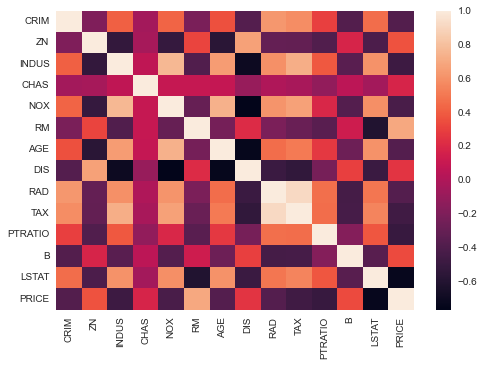

In [370]:
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_df['PRICE'] = boston_target
sns.heatmap(boston_df.corr())
boston_df.corr().PRICE.sort_values()
# boston_df

In [371]:
X = boston_df[['LSTAT', 'PTRATIO', 'TAX', 'INDUS', 'RAD', 'AGE', 'ZN', 'RM']]
y = boston_target

lr_reg = LinearRegression(n_jobs = -1)

X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y), test_size = 0.3, random_state = 0)
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 회귀 평가 지표
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)
print(round(mse, 3), round(rmse, 3), round(r2, 3))

# 회귀계수
pd.Series(data = lr_reg.coef_.reshape(8), index = X.columns)

0.052 0.227 0.668


LSTAT     -0.029801
PTRATIO   -0.036411
TAX       -0.000679
INDUS      0.003860
RAD        0.005272
AGE        0.000231
ZN        -0.000196
RM         0.112576
dtype: float64

Q7. house_df.pkl 데이터셋을 불러와서 아래사항을 수행하세요.(15점)
- alphas = [0, 0.1, 1, 10, 100] 를 적용하여 Ridge 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력 
- lasso_alphas = [0.07,0.1,0.5,1,3] 를 적용, Lasso 회귀 모델링 및 교차 검증 수행 후 5 폴드 평균 RMSE 출력(def get_linear_reg_eval(model_name,params=None,X_data_n=None, y_target_n=None, verbose=True 사용자 함수 이용) 
- elastic_alphas = [0.07,0.1,0.5,1,3] 를 적용, ElasticNet 회귀 모델링 및 교차검증 후 5 폴드 평균 RMSE를 출력(사용자 함수 이용)

정답

In [385]:
house_df = pd.read_pickle('./data/house_df.pkl')
X = house_df.iloc[:, :-1]
y = house_df.iloc[:, -1]

def get_linear_reg_eval(model_name, params, X_data_n, y_target_n, verbose = True):
    coeff_df = pd.DataFrame()
    if verbose == True: print('####', model_name, '#####')
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha = param)
        elif model_name == 'Lasso': model = Lasso(alpha = param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha = param, l1_ratio = 0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring = 'neg_mean_squared_error', cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print(f'alpha{param}일 때 5폴드 세트의 평균 RMSE : {round(avg_rmse, 3)}')
        
alphas = [0, 0.1, 1, 10, 100]
get_linear_reg_eval('Ridge', alphas, X, y)
print()
lasso_alphas = [0.07,0.1,0.5,1,3]
get_linear_reg_eval('Lasso', lasso_alphas, X, y)
print()
elastic_alphas = [0.07,0.1,0.5,1,3]
get_linear_reg_eval('ElasticNet', elastic_alphas, X, y)

#### Ridge #####
alpha0일 때 5폴드 세트의 평균 RMSE : 5.829
alpha0.1일 때 5폴드 세트의 평균 RMSE : 5.788
alpha1일 때 5폴드 세트의 평균 RMSE : 5.653
alpha10일 때 5폴드 세트의 평균 RMSE : 5.518
alpha100일 때 5폴드 세트의 평균 RMSE : 5.33

#### Lasso #####
alpha0.07일 때 5폴드 세트의 평균 RMSE : 5.612
alpha0.1일 때 5폴드 세트의 평균 RMSE : 5.615
alpha0.5일 때 5폴드 세트의 평균 RMSE : 5.669
alpha1일 때 5폴드 세트의 평균 RMSE : 5.776
alpha3일 때 5폴드 세트의 평균 RMSE : 6.189

#### ElasticNet #####
alpha0.07일 때 5폴드 세트의 평균 RMSE : 5.542
alpha0.1일 때 5폴드 세트의 평균 RMSE : 5.526
alpha0.5일 때 5폴드 세트의 평균 RMSE : 5.467
alpha1일 때 5폴드 세트의 평균 RMSE : 5.597
alpha3일 때 5폴드 세트의 평균 RMSE : 6.068


Q8. load_boston 데이터셋을 불러와서 다음사항을 수행하세요.
- SVM 알고리즘을 활용한 주택가격 예측모델 생성 및 평가(MSE, RMSE, R2)
- 개발된 예측모델을 활용하여 아래 test_data가 주어졌은때의 주택가격 예측<br>
test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]

오답

In [376]:
from sklearn.datasets import load_boston

boston = load_boston()
boston_target = pd.DataFrame(boston.target, columns = ['PRICE'])
pd.read_pickle('./data/boston_target.pkl')
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_df['PRICE'] = boston_target

X = boston_df[['LSTAT', 'PTRATIO', 'TAX', 'INDUS', 'RAD', 'AGE', 'ZN', 'RM']]
y = boston_target

Q9. mtcars 데이터셋(mtcars.csv)의 qsec 컬럼을 최소최대 척도(Min-Max Scale)로 변환한 후 0.5보다 
큰 값을 가지는 레코드 수를 구하시오

정답

In [383]:
mtcars = pd.read_csv('./data/mtcars.csv', index_col = 0)
a = MinMaxScaler().fit_transform(mtcars['qsec'].values.reshape(-1, 1))
len(a[a > 0.5])

9

Q10. purdata.csv는 백화점 고객의 1년 간 구매 데이터이다. 아래사항을 수행하세요.
 
- 남성고객을 분류하는 모델을 생성(분류알고리즘 : dt,rf,lr)
- 모델 성능을 roc_auc로 평가 

정답

In [368]:
purdata = pd.read_csv('./data/purdata.csv', index_col = 0)
purdata['환불금액'].fillna(0, inplace = True)
purdata1 = purdata.drop(['총구매액'], axis = 1)
display(purdata1.head())

X = purdata1.iloc[:, :-1]
X1 = pd.get_dummies(X)
y = purdata1.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.3, random_state = 0, stratify = y)

dt = DecisionTreeClassifier(random_state = 0)
rf = RandomForestClassifier(random_state = 0, n_jobs = -1)
lr = LogisticRegression(n_jobs = -1)

for i in [dt, rf, lr]:
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    pred_proba = i.predict_proba(X_test)[:, 1]
    print(i)
    get_eval(y_test, pred, pred_proba)
    print()

,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
cust_id,,,,,,,,,
0,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
1,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1,0
2,1639000,0.0,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,4935000,0.0,기타,광주점,18,2.444444,0.318182,16,1
4,24000000,0.0,보석,본 점,2,1.500000,0.000000,85,0


DecisionTreeClassifier(random_state=0)
오차행렬 : 
[[456 199]
 [208 187]] 

정확도 : 0.612 
정밀도 : 0.484 
재현율 : 0.473 
f1 : 0.479 
auc : 0.585

RandomForestClassifier(n_jobs=-1, random_state=0)
오차행렬 : 
[[552 103]
 [259 136]] 

정확도 : 0.655 
정밀도 : 0.569 
재현율 : 0.344 
f1 : 0.429 
auc : 0.670

LogisticRegression(n_jobs=-1)
오차행렬 : 
[[655   0]
 [395   0]] 

정확도 : 0.624 
정밀도 : 0.000 
재현율 : 0.000 
f1 : 0.000 
auc : 0.638

